<a id='Title-Generative-Adversarial-Networks'></a>
<h1 style="color:SlateGray;">Generative Adversarial Networks</h1>

**Input dataset**

CIFAR10: a set of 32x32 images from 10 different classes.

**Output**

Generated images that are iteratively less distinguishable from the input images.

<h2 style="color:SlateGray;">Background</h2>

**Layers**

[*Dense*](01_Image_Classification.ipynb#Layers-Dense)

[*Conv2D*](06_Basic_ConvNet.ipynb#Layers-Conv2D)

[*Dropout*](05_Overfitting_And_Underfitting.ipynb#Layers-Dropout)

[*Conv2DTranspose*](19_Variational_Autoencoders.ipynb#Layers-Conv2DTranspose)

<a id='Layers-LeakyReLU'></a>
*LeakyReLU*

**Activations**

[*sigmoid*](02_Binary_Classification.ipynb#Activations-sigmoid)

<a id='Activations-tanh'></a>
*tanh*


		
**Optimizers**

[*rmsprop*](01_Image_Classification.ipynb#Optimizers-rmsprop)
		
**Loss functions**

[*binary_crossentropy*](02_Binary_Classification.ipynb#Loss-functions-binary_crossentropy)

<h2 style="color:SlateGray;">Overview</h2>



In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

In [2]:
import os
from keras.preprocessing import image

latent_dim = 32
height = 32
width = 32
channels = 3

(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

x_train = x_train[y_train.flatten() == 6]
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

if not os.path.isdir('./gan_images/'):
    os.mkdir('./gan_images/')
    
save_dir = './gan_images/'

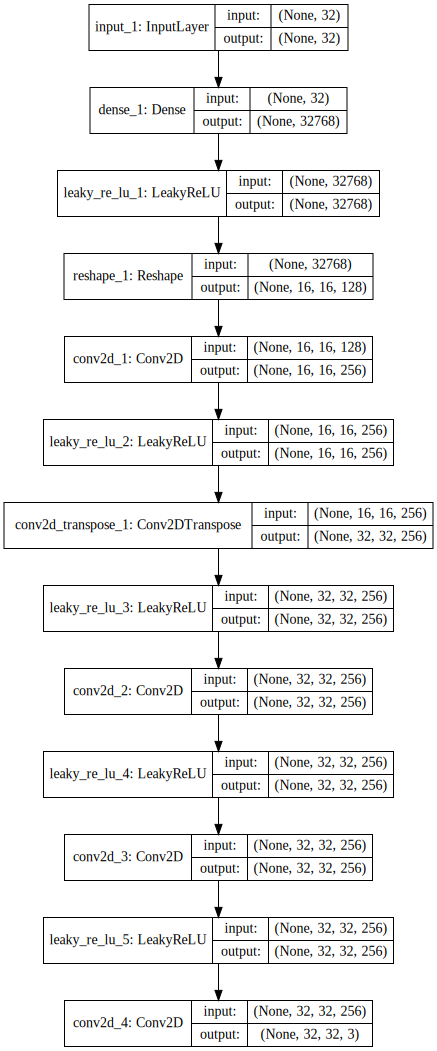

In [3]:
import keras
from keras import layers
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x, name='generator')

SVG(model_to_dot(generator, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

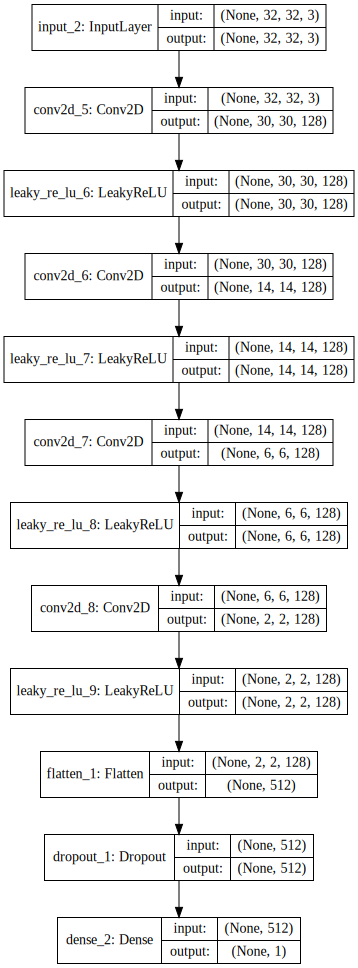

In [4]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x, name='discriminator')

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

SVG(model_to_dot(discriminator, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

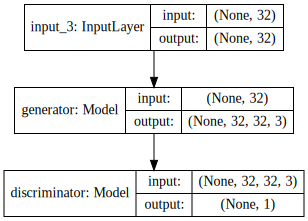

In [5]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output, name='gan')

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

SVG(model_to_dot(gan, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

In [6]:
iterations = 10000
batch_size = 20
start = 0

for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    generated_images = generator.predict(random_latent_vectors)

    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)

    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    misleading_targets = np.zeros((batch_size, 1))
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    if step % 100 == 0:
        gan.save_weights('gan.h5')

        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

c:\users\manny\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.67858773
adversarial loss at step 0: 0.67934245
discriminator loss at step 100: 0.58842623
adversarial loss at step 100: 1.5321516
discriminator loss at step 200: 0.6758231
adversarial loss at step 200: 0.6851011
discriminator loss at step 300: 0.69482243
adversarial loss at step 300: 0.75217533
discriminator loss at step 400: 0.6963202
adversarial loss at step 400: 0.74301344
discriminator loss at step 500: 0.6968324
adversarial loss at step 500: 0.7501561
discriminator loss at step 600: 0.6983191
adversarial loss at step 600: 0.7751452
discriminator loss at step 700: 0.6903287
adversarial loss at step 700: 0.75051516
discriminator loss at step 800: 0.69304866
adversarial loss at step 800: 0.7425307
discriminator loss at step 900: 0.71014625
adversarial loss at step 900: 0.7725404
discriminator loss at step 1000: 0.6966798
adversarial loss at step 1000: 0.75478977
discriminator loss at step 1100: 0.6916497
adversarial loss at step 1100: 0.7650782
discri

discriminator loss at step 9700: 0.6546879
adversarial loss at step 9700: 0.79041016
discriminator loss at step 9800: 0.68397725
adversarial loss at step 9800: 0.92606175
discriminator loss at step 9900: 0.78758657
adversarial loss at step 9900: 1.0451921


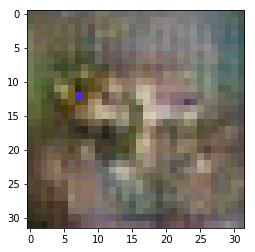

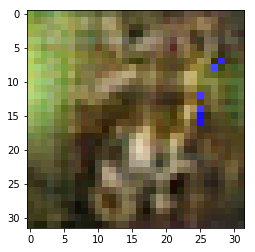

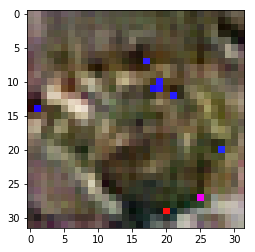

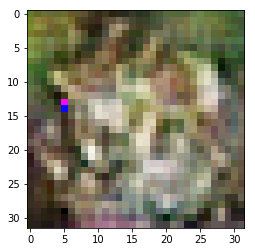

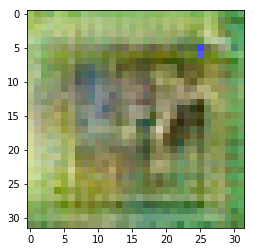

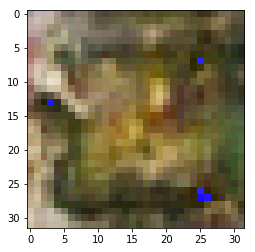

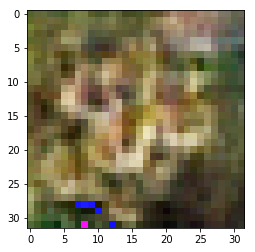

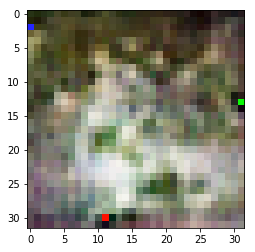

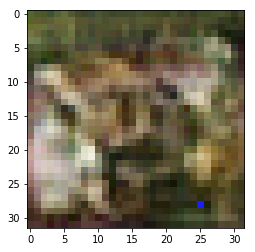

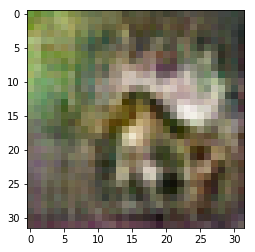

In [8]:
import matplotlib.pyplot as plt

random_latent_vectors = np.random.normal(size=(10, latent_dim))
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()